# 第四章　暖冷房設備 / Chapter 4 Heating and cooling equipment

## 第三節　ルームエアコンディショナー / Section 3  Room Air Conditioner

In [1]:
import numpy as np

## 試算例

### 初期条件

In [2]:
def get_default_rac():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34}
    house_ENV = {"A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'method': '当該住宅の外皮面積の合計を用いて評価する'}

    H_MR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
    H_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
    C_MR = {"type": "ルームエアコンディショナー", 'e_class': 'ろ', 'dualcompressor': False}
    C_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
    i = 1
    
    return house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i

### 計算

In [3]:
def calc_results(house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i):

    from pyhees.section4_1 import get_virtual_heating_devices, calc_A_HCZ_i, get_alpha_UT_H_MR, get_alpha_UT_H_OR
    from pyhees.section4_1_a import calc_heating_mode
    from pyhees.section2_1_b import get_f_prim
    from pyhees.section2_2 import calc_heating_load, calc_cooling_load
    from pyhees.section3_1 import get_Q
    from pyhees.section3_2 import calc_insulation_performance
    from pyhees.section4_3 import calc_E_E_H_d_t, get_E_G_H_d_t, get_E_K_H_d_t, get_E_M_H_d_t, calc_Q_UT_H_d_t, calc_E_E_C_d_t, get_E_G_C_d_t, get_E_K_C_d_t, get_E_M_C_d_t
    from pyhees.section4_3_a import get_q_rtd_C, get_q_rtd_H, get_e_rtd_C, get_e_rtd_H


    sol_region = None
    NV_MR = 0
    NV_OR = 0
    r_A_ufvnt = None
    underfloor_insulation = False
    TS = None
    HEX = None
    SHC = None

    mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'
    mode_C = '居室のみを冷房する方式'

    house_ENV['A_A'] = house_base['A_A']


    # ---- 外皮の計算 ----

    # 外皮の断熱性能の計算
    if house_ENV is not None:
        U_A, _, _, _, Q_dash, eta_H, eta_C, _ = calc_insulation_performance(**house_ENV)
        # 熱損失係数
        Q = get_Q(Q_dash)
        A_env = house_ENV.get('A_env')
    else:
        Q = None
        eta_H, eta_C = None, None
        A_env = None

    
    # 実質的な暖房機器の仕様を取得
    spec_MR, spec_OR = get_virtual_heating_devices(house_base['region'], H_MR, H_OR)

    # 暖房方式及び運転方法の区分
    mode_MR, mode_OR = calc_heating_mode(region=house_base['region'], H_MR=spec_MR, H_OR=spec_OR)

    # 暖房負荷の取得
    L_T_H_d_t_i, _ = calc_heating_load(house_base['region'], sol_region, house_base['A_A'], house_base['A_MR'], house_base['A_OR'],
                        Q, eta_H, eta_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX, underfloor_insulation, mode_H, mode_C, spec_MR, spec_OR, mode_MR, mode_OR, SHC)

    # 暖冷房仕様の取得
    A_HCZ = calc_A_HCZ_i(i, house_base['A_A'], house_base['A_MR'], house_base['A_OR'])
    q_rtd_C = get_q_rtd_C(A_HCZ)
    q_rtd_H = get_q_rtd_H(q_rtd_C)

    if i == 1 and H_MR is not None:
        e_rtd_C = get_e_rtd_C(H_MR['e_class'], q_rtd_C)
        dualcompressor_H = H_MR['dualcompressor']
    elif 2 <= i <= 5 and H_OR is not None:
        e_rtd_C = get_e_rtd_C(H_OR['e_class'], q_rtd_C)
        dualcompressor_H = H_OR['dualcompressor']
    else:
        e_rtd_C = None
    
    e_rtd_H = get_e_rtd_H(e_rtd_C)


    # 暖房用の電気消費量
    E_E_H_d_t = calc_E_E_H_d_t(region=house_base['region'], q_rtd_C=q_rtd_C, q_rtd_H=q_rtd_H, e_rtd_H=e_rtd_H, dualcompressor=dualcompressor_H, L_H_d_t=L_T_H_d_t_i[i-1])
    # print(f'E_E_H = {np.sum(E_E_H_d_t)}kWh/a')

    # 暖房用のガス消費量
    E_G_H_d_t = get_E_G_H_d_t()

    # 暖房用の灯油
    E_K_H_d_t = get_E_K_H_d_t()

    # 暖房用のその他の燃料
    E_M_H_d_t = get_E_M_H_d_t()

    # 未処理暖房負荷の設計一次エネルギー消費量相当値
    Q_UT_H_d_t = calc_Q_UT_H_d_t(house_base['region'], q_rtd_C, q_rtd_H, e_rtd_H, L_H_d_t=L_T_H_d_t_i[i-1])
    alpha_UT_H = get_alpha_UT_H_MR(house_base['region'], mode_MR) if i == 1 else get_alpha_UT_H_OR(house_base['region'], mode_OR)
    E_UT_H_d_t = Q_UT_H_d_t * alpha_UT_H



    # 冷房負荷の取得
    L_CS_d_t, L_CL_d_t = calc_cooling_load(house_base['region'], house_base['A_A'], house_base['A_MR'], house_base['A_OR'], Q, eta_H, eta_C, NV_MR, NV_OR, 
                          r_A_ufvnt, underfloor_insulation, mode_C, mode_H, mode_MR, mode_OR, TS, HEX)

    # 冷房設備の仕様の取得
    if i == 1 and C_MR is not None:
        e_rtd_C = get_e_rtd_C(C_MR['e_class'], q_rtd_C)
        dualcompressor_C = C_MR['dualcompressor']
    elif 2 <= i <= 5 and H_OR is not None:
        e_rtd_C = get_e_rtd_C(C_OR['e_class'], q_rtd_C)
        dualcompressor_C = C_OR['dualcompressor']
    else:
        e_rtd_C = None
        dualcompressor_C = None
    
    e_rtd_H = get_e_rtd_H(e_rtd_C)


    # 冷房用の電気消費量
    E_E_C_d_t = calc_E_E_C_d_t(region=house_base['region'], q_rtd_C=q_rtd_C, e_rtd_C=e_rtd_C, dualcompressor=dualcompressor_C, \
                                L_CS_d_t=L_CS_d_t[i - 1], L_CL_d_t=L_CL_d_t[i - 1])

    # 冷房用のガス消費量
    E_G_C_d_t = get_E_G_C_d_t()

    # 冷房用の灯油消費量
    E_K_C_d_t = get_E_K_C_d_t()

    # 冷房用のその他の燃料
    E_M_C_d_t = get_E_M_C_d_t()

    # 未処理冷房負荷の設計一次エネルギー消費量相当値
    E_UT_C_d_t = np.zeros(365 * 24)


    # 電気の一次エネルギー換算係数
    f_prim = get_f_prim()

    E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t
    E_C_d_t = E_E_C_d_t * f_prim / 1000 + E_G_C_d_t + E_K_C_d_t + E_M_C_d_t + E_UT_C_d_t
    print(f'E_H_d_t(i={i})={np.sum(E_H_d_t)}MJ/a')
    print(f'E_C_d_t(i={i})={np.sum(E_C_d_t)}MJ/a')
    
    return E_H_d_t, E_C_d_t

In [4]:
def get_each_graph(_E_H_d_t, _E_C_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)
    _E_C_d = np.sum(_E_C_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_C_d, label = "E_C")    
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')

    grh_date.plot(_E_C_d_t.reshape(365,24)[151], label = "E_C:6/1")
    grh_date.plot(_E_C_d_t.reshape(365,24)[212], label = "E_C:8/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

- 初期条件での計算

In [5]:
house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i = get_default_rac()
_E_H_d_t_1, _E_C_d_t_1 = calc_results(house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i)

E_H_d_t(i=1)=10478.692099447626MJ/a
E_C_d_t(i=1)=3287.9122989004436MJ/a


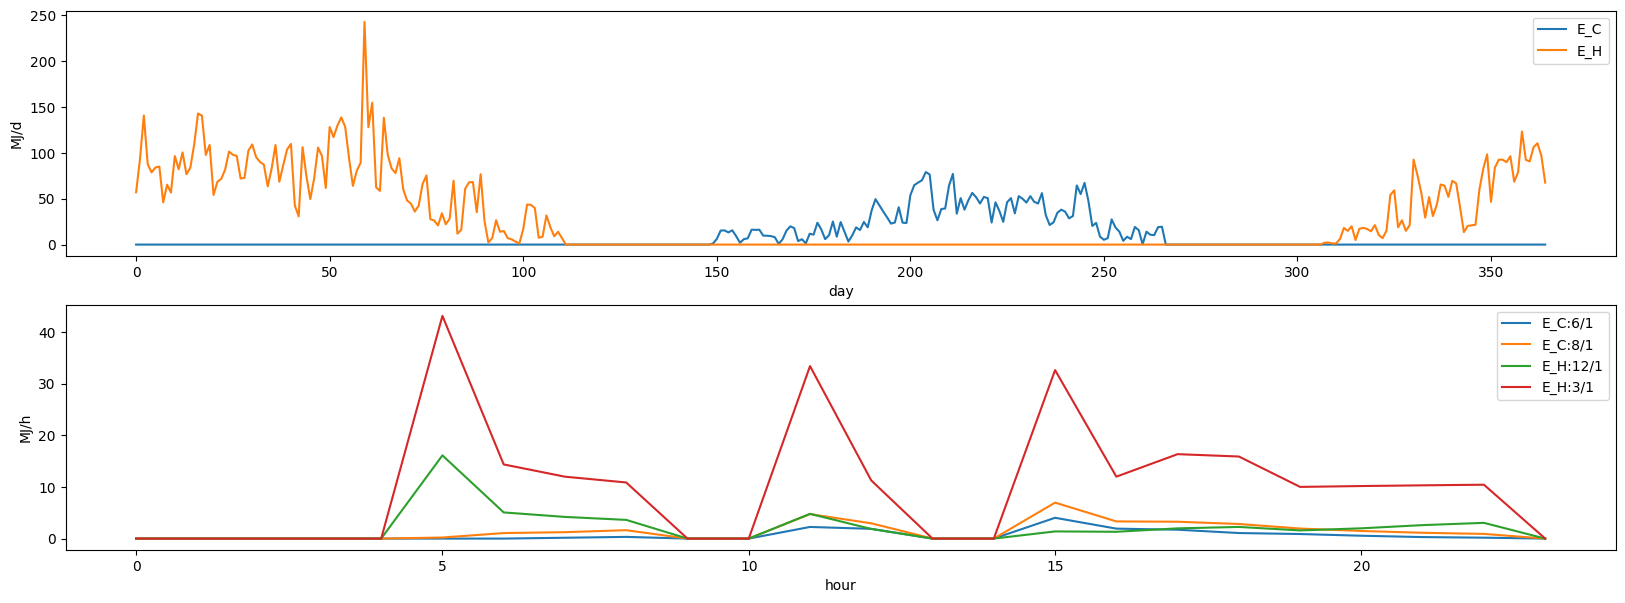

In [6]:
get_each_graph(_E_H_d_t_1, _E_C_d_t_1)

### 計算条件2

- 主たる居室、その他居室の暖房設備及び冷房設備のエネルギー消費効率を（い）に変更

In [7]:
house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i = get_default_rac()
H_MR['e_class'] = 'い'
H_OR['e_class'] = 'い'
C_MR['e_class'] = 'い'
C_OR['e_class'] = 'い'
_E_H_d_t_2, _E_C_d_t_2 = calc_results(house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i)

E_H_d_t(i=1)=10132.937050655002MJ/a
E_C_d_t(i=1)=3099.7535289584343MJ/a


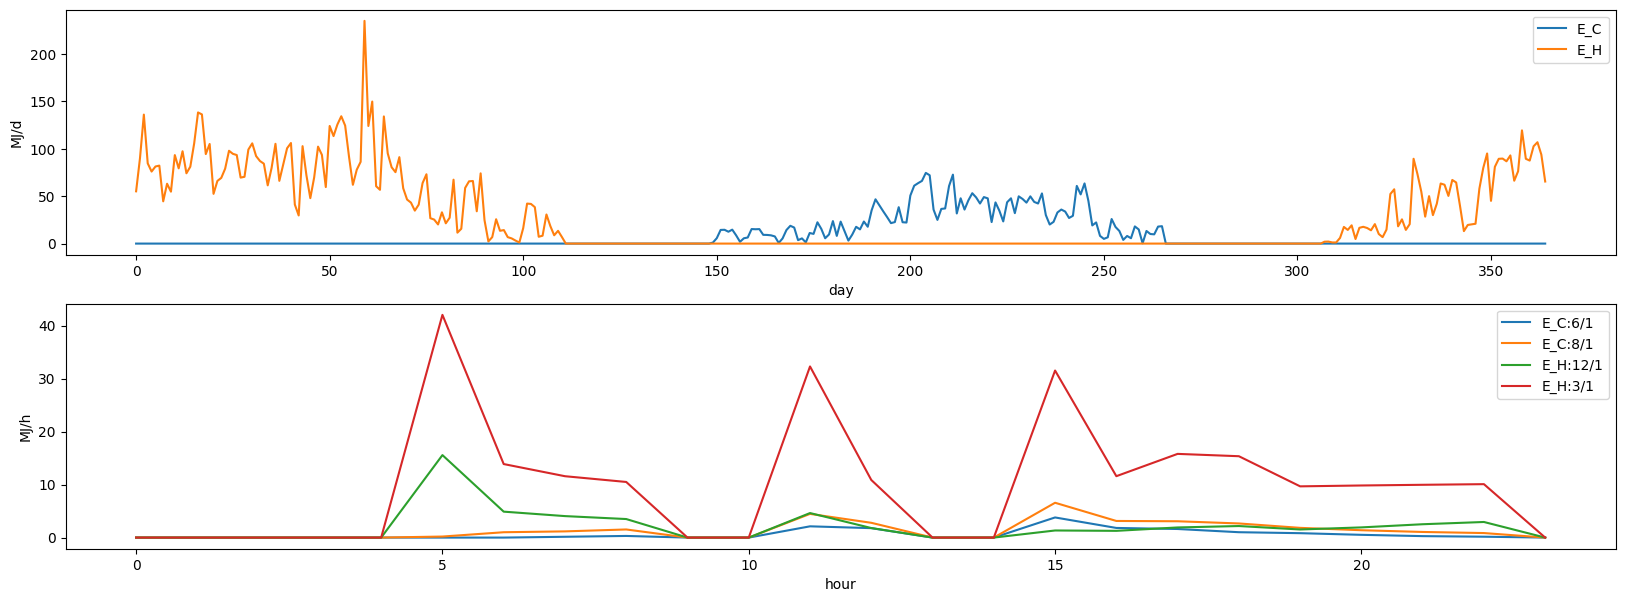

In [8]:
get_each_graph(_E_H_d_t_2, _E_C_d_t_2)

### 計算条件3

- 主たる居室、その他居室の暖房設備及び冷房設備に小能力時高効率型コンプレッサーを搭載

In [9]:
house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i = get_default_rac()
H_MR['dualcompressor'] = True
H_OR['dualcompressor'] = True
C_MR['dualcompressor'] = True
C_OR['dualcompressor'] = True

_E_H_d_t_3, _E_C_d_t_3 = calc_results(house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i)

E_H_d_t(i=1)=9660.784345619591MJ/a
E_C_d_t(i=1)=4040.5856388875322MJ/a


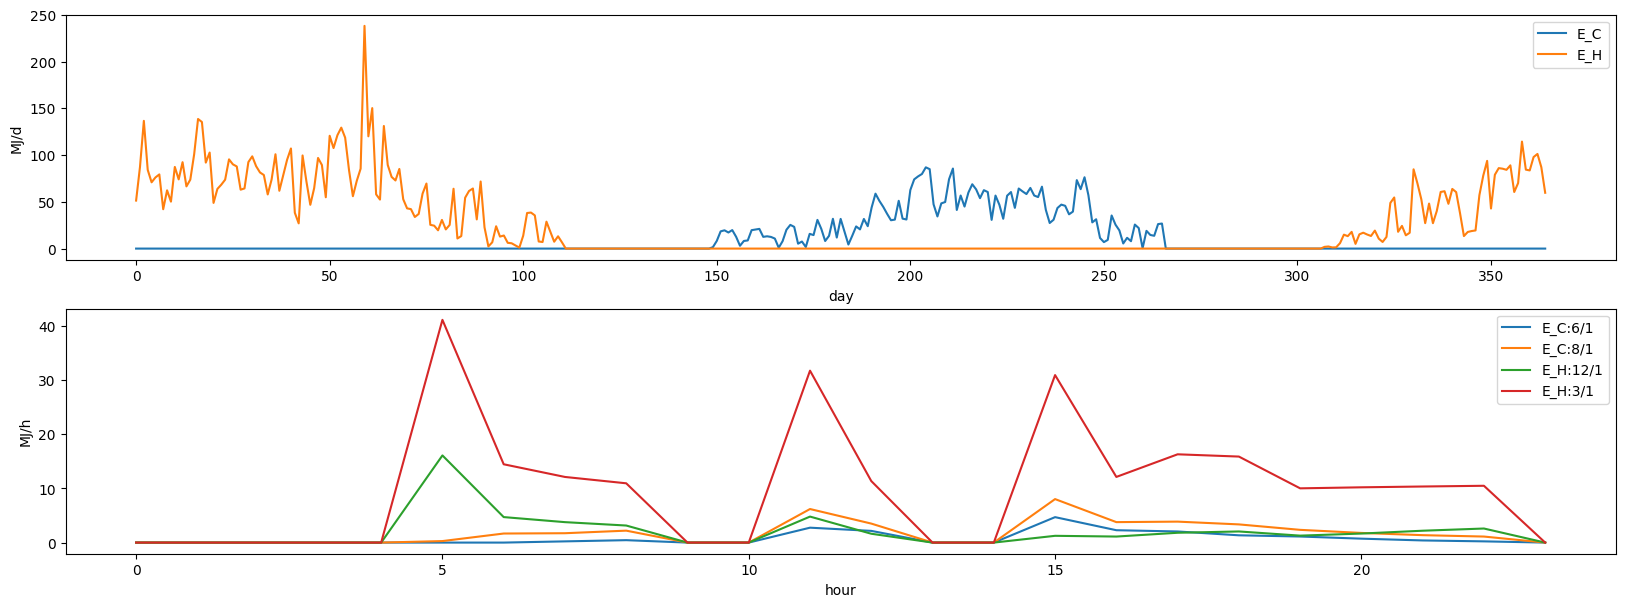

In [10]:
get_each_graph(_E_H_d_t_3, _E_C_d_t_3)

### 計算条件4

- UA値を0.6に変更
- 主たる居室、その他居室の暖房設備及び冷房設備のエネルギー消費効率を（い）に変更

In [11]:
house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i = get_default_rac()
house_ENV["U_A"] = 0.6
H_MR['e_class'] = 'い'
H_OR['e_class'] = 'い'
C_MR['e_class'] = 'い'
C_OR['e_class'] = 'い'

_E_H_d_t_4, _E_C_d_t_4 = calc_results(house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i)

E_H_d_t(i=1)=6747.982138049518MJ/a
E_C_d_t(i=1)=3550.7426033740544MJ/a


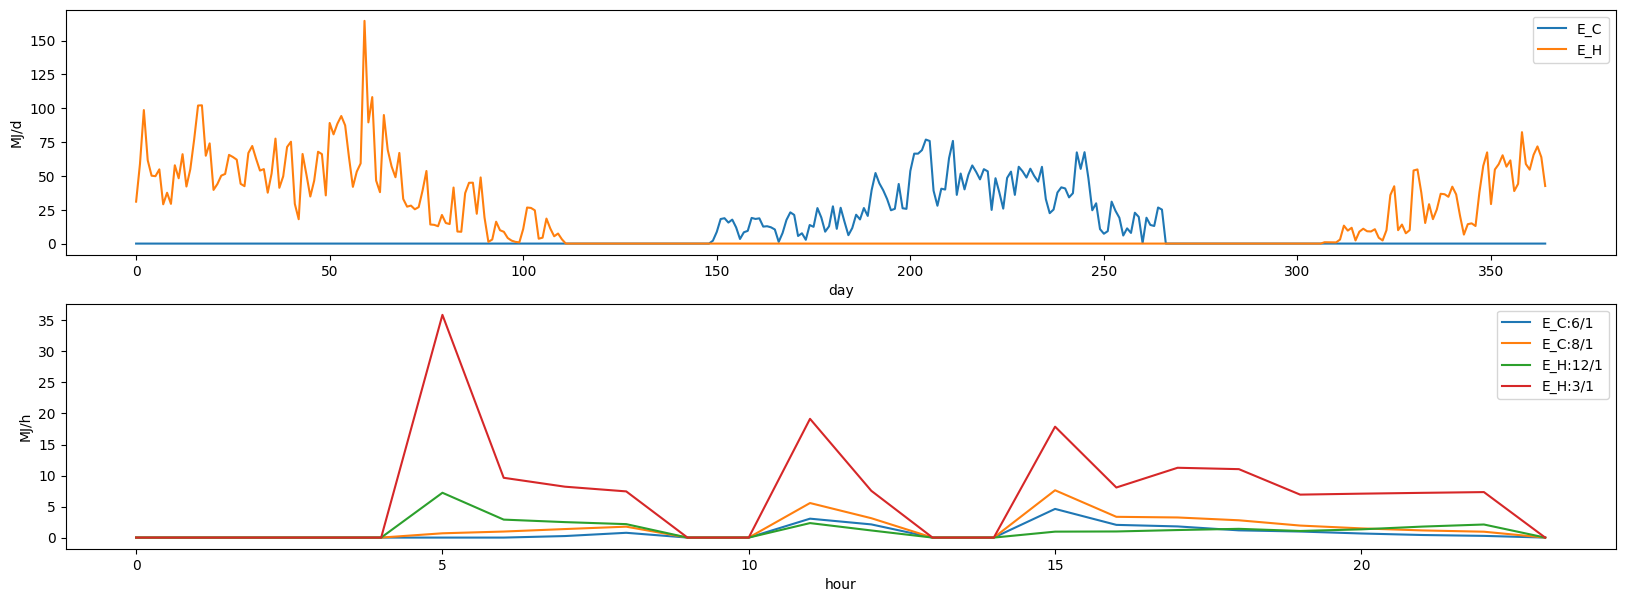

In [12]:
get_each_graph(_E_H_d_t_4, _E_C_d_t_4)

### 計算条件5

- UA値を0.46に変更
- 主たる居室、その他居室の暖房設備及び冷房設備のエネルギー消費効率を（い）に変更

In [13]:
house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i = get_default_rac()
house_ENV["U_A"] = 0.46
H_MR['e_class'] = 'い'
H_OR['e_class'] = 'い'
C_MR['e_class'] = 'い'
C_OR['e_class'] = 'い'

_E_H_d_t_5, _E_C_d_t_5 = calc_results(house_base, house_ENV, H_MR, H_OR, C_MR, C_OR, i)

E_H_d_t(i=1)=4715.429324227698MJ/a
E_C_d_t(i=1)=3794.425571111422MJ/a


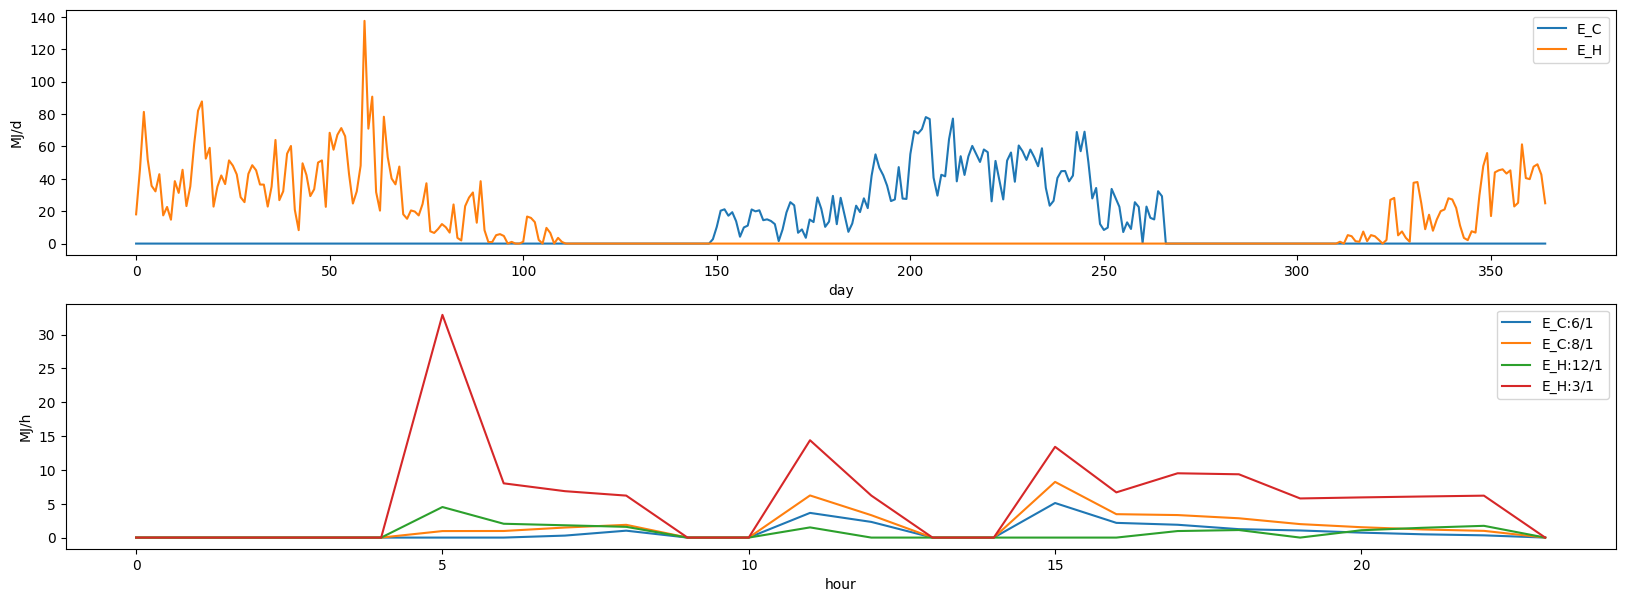

In [14]:
get_each_graph(_E_H_d_t_5, _E_C_d_t_5)

## 試算例の比較

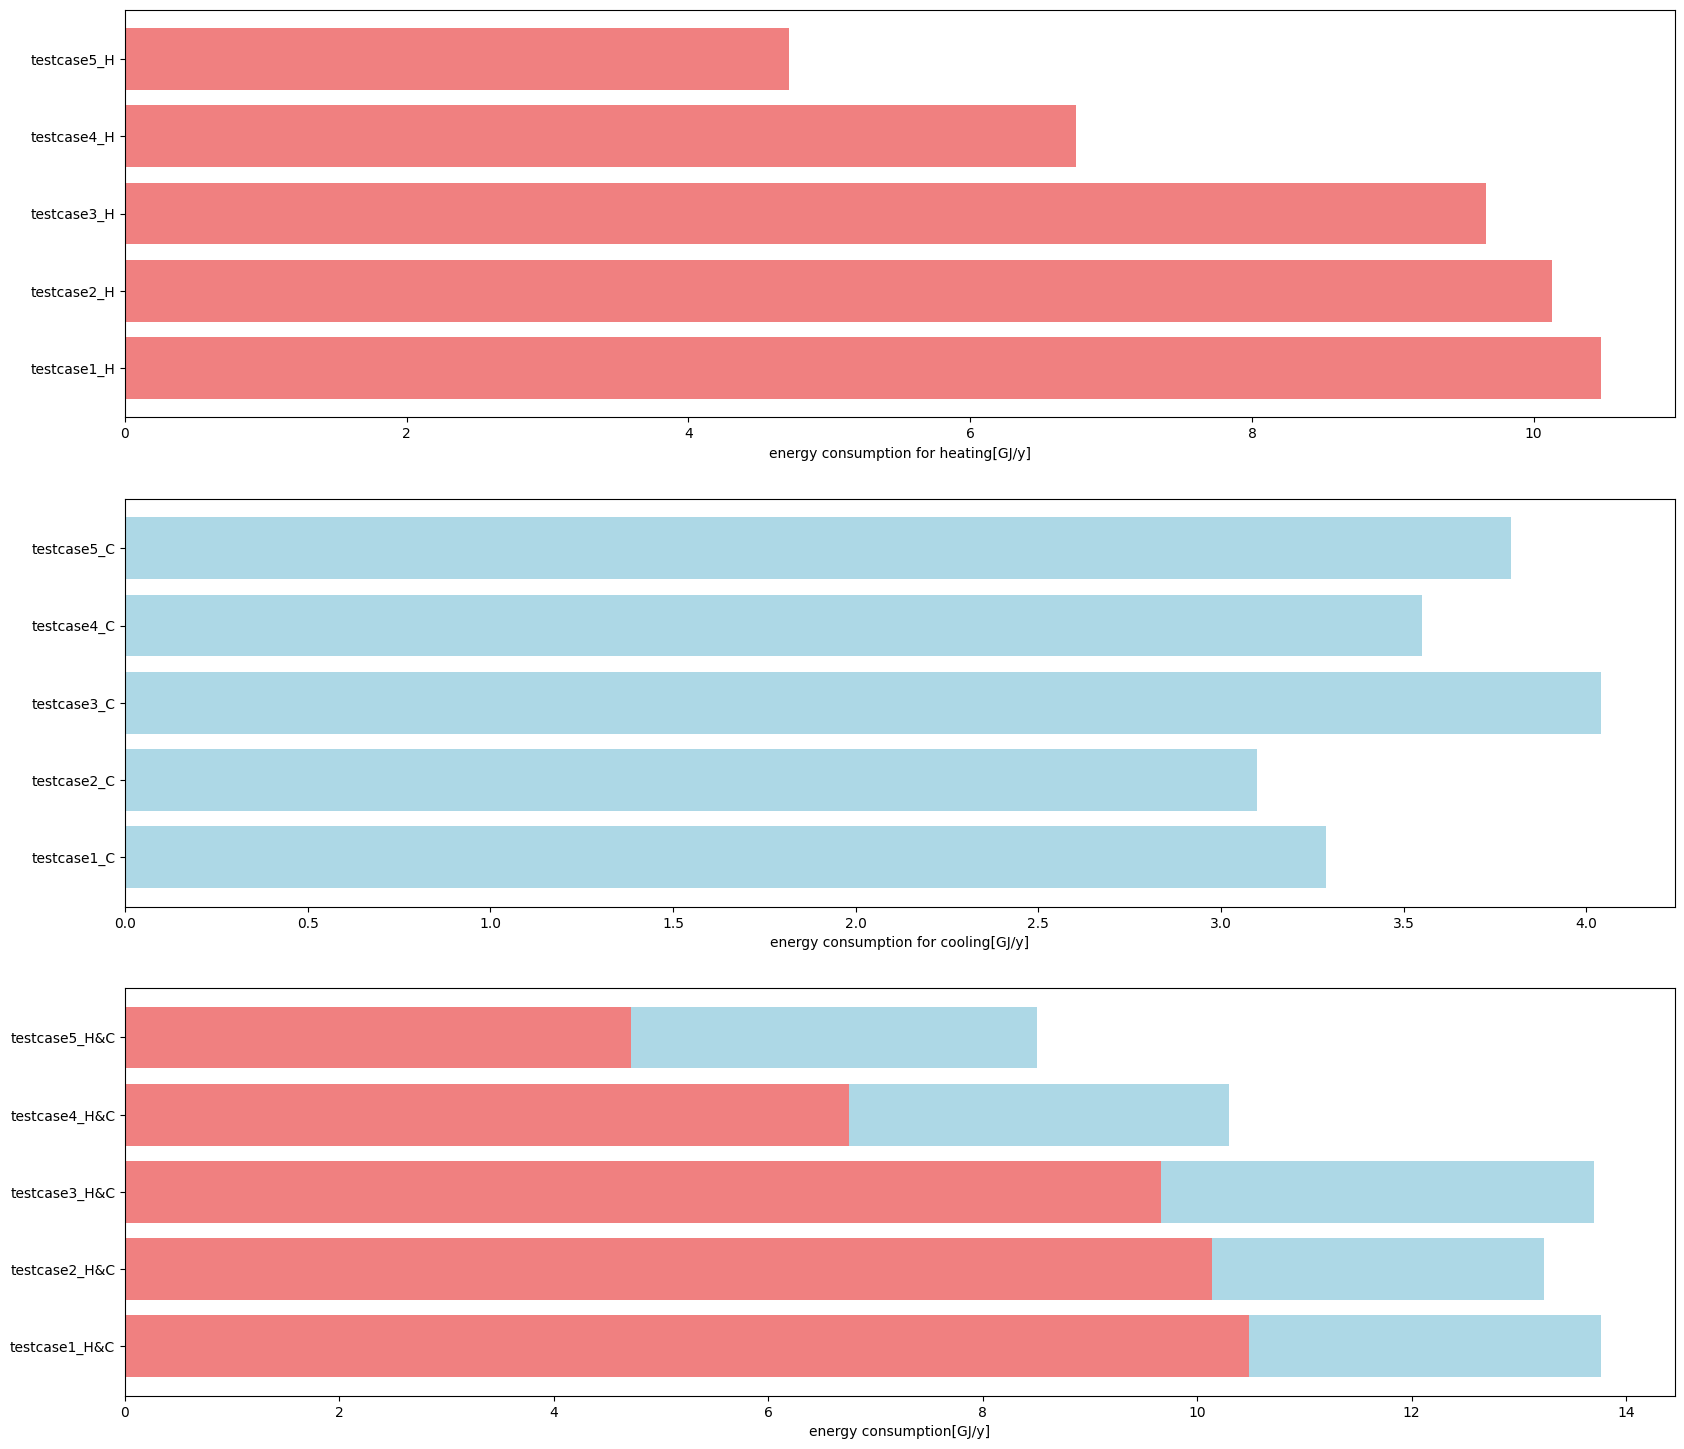

In [15]:
import matplotlib.pyplot as plt

dat_H = {"testcase1_H": np.sum(_E_H_d_t_1)/1000, "testcase2_H": np.sum(_E_H_d_t_2)/1000, "testcase3_H": np.sum(_E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(_E_H_d_t_4)/1000, "testcase5_H": np.sum(_E_H_d_t_5)/1000}

dat_C = {"testcase1_C": np.sum(_E_C_d_t_1)/1000, "testcase2_C": np.sum(_E_C_d_t_2)/1000, "testcase3_C": np.sum(_E_C_d_t_3)/1000, 
         "testcase4_C": np.sum(_E_C_d_t_4)/1000, "testcase5_C": np.sum(_E_C_d_t_5)/1000}


x_H = list(dat_H.keys())
y_H = list(dat_H.values())

x_C = list(dat_C.keys())
y_C = list(dat_C.values())

x_HC = ["testcase1_H&C", "testcase2_H&C", "testcase3_H&C", "testcase4_H&C", "testcase5_H&C"]

fig = plt.figure(figsize=(20,18))

grh_H = fig.add_subplot(311)
grh_H.barh(x_H,y_H, color = "lightcoral")
grh_H.set_xlabel("energy consumption for heating[GJ/y]")

grh_C = fig.add_subplot(312)
grh_C.barh(x_C,y_C, color = "lightblue")
grh_C.set_xlabel("energy consumption for cooling[GJ/y]")

grh_HC = fig.add_subplot(313)
grh_HC.barh(x_HC, y_H, color = "lightcoral")
grh_HC.barh(x_HC, y_C, left=y_H, color="lightblue")
grh_HC.set_xlabel("energy consumption[GJ/y]")

plt.show()